In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import glob
import torch
import statistics
import seaborn as sns
import time
import random
import keras.backend as K
import glob
import os
import pandas as pd


from tensorflow.keras import layers
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, train_test_split
from keras.optimizers import SGD, Adagrad, Adam, Nadam
from sklearn.metrics import confusion_matrix
from google.colab import files

In [2]:
# Take dataset directly from Kaggle

!pip install opendatasets
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/aliaslandemir/classcrossfin")

# Kaggle username: aliaslandemir
# Kaggle Key: 6f8335ed8437205e08381585952f57ed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./classcrossfin" (use force=True to force download)


In [3]:
# Using pandas dataframe to load images with labels taken from https://www.kaggle.com/code/taejoopark/kfold-for-small-image-dataset-vgg16-94-test-acc/notebook

data_path = 'classcrossfin'

# Glob all 'jpg' image files
img_paths = glob.glob(data_path + '/**/*.jpg', recursive=True)

# Extract label names from file directory
img_labels = [os.path.split(os.path.dirname(path))[1] for path in img_paths]

# Create a DataFrame to store paths and labels
img_df = pd.DataFrame({'PATH': img_paths, 'LABELS': img_labels})

# Shuffle the DataFrame
img_df = img_df.sample(frac=1).reset_index(drop=True)

# Split the dataset into training and test sets
train_df, test_df = train_test_split(img_df, train_size=0.8, shuffle=True)

In [4]:
# Image data generator

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Set the batch size and image size
batch_size = 16
width = 200
height = 200

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='PATH',
    y_col='LABELS',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Test data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='PATH',
    y_col='LABELS',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 1164 validated image filenames belonging to 2 classes.
Found 292 validated image filenames belonging to 2 classes.


In [5]:
# Neural network model

model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 16)       0

In [6]:
# Compile the model

model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/10
73/73 [==============================] - 12s 66ms/step - loss: 0.6519 - accuracy: 0.6263 - val_loss: 0.5033 - val_accuracy: 0.7774
Epoch 2/10
73/73 [==============================] - 2s 33ms/step - loss: 0.4727 - accuracy: 0.7998 - val_loss: 0.4426 - val_accuracy: 0.8048
Epoch 3/10
73/73 [==============================] - 3s 37ms/step - loss: 0.4048 - accuracy: 0.8170 - val_loss: 0.3970 - val_accuracy: 0.8459
Epoch 4/10
73/73 [==============================] - 2s 34ms/step - loss: 0.4231 - accuracy: 0.8230 - val_loss: 0.3936 - val_accuracy: 0.8562
Epoch 5/10
73/73 [==============================] - 2s 29ms/step - loss: 0.3826 - accuracy: 0.8402 - val_loss: 0.3909 - val_accuracy: 0.8219
Epoch 6/10
73/73 [==============================] - 2s 29ms/step - loss: 0.3785 - accuracy: 0.8445 - val_loss: 0.4101 - val_accuracy: 0.8185
Epoch 7/10
73/73 [==============================] - 2s 29ms/step - loss: 0.3632 - accuracy: 0.8445 - val_loss: 0.3595 - val_accuracy: 0.8562
Epoch 8/10
7

In [7]:
# Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 0s 21ms/step - loss: 0.4065 - accuracy: 0.8185
Test Loss: 0.4065108597278595
Test Accuracy: 0.818493127822876


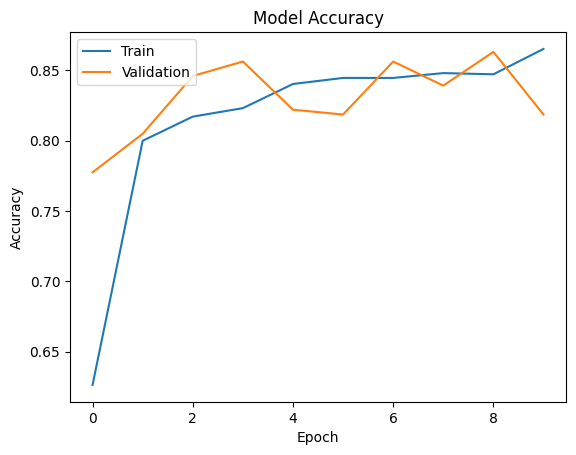

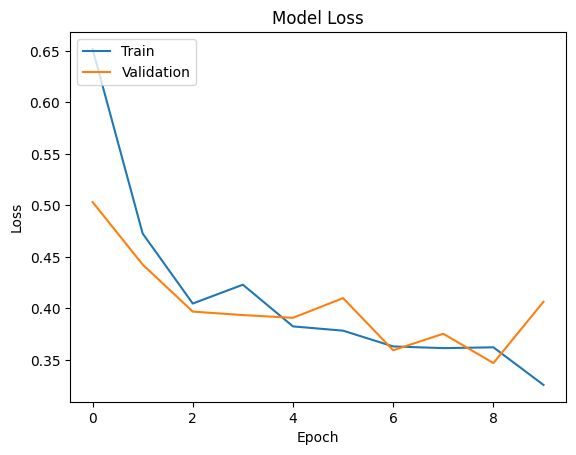

In [8]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
